# Dask DataFrame (1)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Dask DataFrame"
* https://docs.dask.org/en/latest/dataframe.html
* Jesse C. Daniel. Data Science with Python and Dask. 

* https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.memory_usage_per_partition.html#dask.dataframe.DataFrame.memory_usage_per_partition
* https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.map_partitions.html#dask.dataframe.DataFrame.map_partitions
* https://docs.dask.org/en/stable/generated/dask.array.histogram.html
* https://docs.dask.org/en/stable/dataframe-categoricals.html
* https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.pivot_table.html#dask.dataframe.DataFrame.pivot_table

* https://docs.dask.org/en/stable/best-practices.html
* https://docs.dask.org/en/stable/dashboard.html
* https://distributed.dask.org/en/stable/client.html

## Задачи для совместного разбора

1\. Создать `dask.DataFrame`. Рассмотреть основные возможности (выбор строк, работа с датами, добавление столбцов)

In [2]:
import dask
import dask.dataframe as dd
import pandas as pd

In [6]:
df = dask.datasets.timeseries(start='2023-05-04', end='2023-05-06')
df

,id,name,x,y
npartitions=2,,,,
2023-05-04,int32,object,float64,float64
2023-05-05,...,...,...,...
2023-05-06,...,...,...,...


In [7]:
df.head(3)

,id,name,x,y
timestamp,,,,
2023-05-04 00:00:00,1003,Jerry,-0.306816,0.552244
2023-05-04 00:00:01,1005,Quinn,-0.687777,-0.698835
2023-05-04 00:00:02,971,Charlie,-0.208793,0.439755


In [8]:
Jerrys = df[df['name'] == "Jerry"]
Jerrys.head(3)

,id,name,x,y
timestamp,,,,
2023-05-04 00:00:00,1003,Jerry,-0.306816,0.552244
2023-05-04 00:00:22,935,Jerry,-0.997517,0.489223
2023-05-04 00:00:49,984,Jerry,0.697882,0.698943


In [12]:
df.query("name == 'Jerry'").head(3)

,id,name,x,y
timestamp,,,,
2023-05-04 00:00:00,1003,Jerry,-0.306816,0.552244
2023-05-04 00:00:22,935,Jerry,-0.997517,0.489223
2023-05-04 00:00:49,984,Jerry,0.697882,0.698943


In [13]:
df.index.dt.year.head(5)

Int64Index([2023, 2023, 2023, 2023, 2023], dtype='int64', name='timestamp')

In [16]:
df['key'] = df['name'].map(lambda n: n[0])
df.head(5)

,id,name,x,y,key
timestamp,,,,,
2023-05-04 00:00:00,1003,Jerry,-0.306816,0.552244,J
2023-05-04 00:00:01,1005,Quinn,-0.687777,-0.698835,Q
2023-05-04 00:00:02,971,Charlie,-0.208793,0.439755,C
2023-05-04 00:00:03,1011,Ray,-0.970550,0.702061,R
2023-05-04 00:00:04,1044,Ursula,0.106306,-0.962286,U


In [17]:
df['name'].unique().compute()

0        Jerry
1        Quinn
2      Charlie
3          Ray
4       Ursula
5       Ingrid
6        Sarah
7          Dan
8     Patricia
9        Wendy
10       Edith
11     Michael
12      Hannah
13         Tim
14       Frank
15      George
16      Yvonne
17         Bob
18      Oliver
19       Zelda
20     Norbert
21       Laura
22       Alice
23       Kevin
24      Xavier
25      Victor
Name: name, dtype: object

2\. Используя метод pipe, добавьте столбец с полом человека и нормализуйте столбцы x и y

In [22]:
def add_key(df):
    df['key'] = df['name'].map(lambda n: n[0])
    return df

def add_gender(df):
    df['gender'] = 'f'
    males = {'Bob', 'Tim', 'Oliver'}
    df['gender'] = df['gender'].mask(df['name'].isin(males), 'm')
    return df

def normalize(df, colname):
    df[colname] = df[colname] / df[colname].max()
    return df

In [23]:
df_t = df.pipe(add_key).pipe(add_gender).pipe(normalize, colname='x').pipe(normalize, colname='y')

In [24]:
df_t

,id,name,x,y,key,gender
npartitions=2,,,,,,
2023-05-04,int32,object,float64,float64,object,object
2023-05-05,...,...,...,...,...,...
2023-05-06,...,...,...,...,...,...


3\. При помощи сводных таблиц посчитайте для каждой пары (gender, key) среднее значение по столбцу x.

In [25]:
df_t.head()

,id,name,x,y,key,gender
timestamp,,,,,,
2023-05-04 00:00:00,1003,Jerry,-0.306822,0.552264,J,f
2023-05-04 00:00:01,1005,Quinn,-0.687790,-0.698860,Q,f
2023-05-04 00:00:02,971,Charlie,-0.208797,0.439772,C,f
2023-05-04 00:00:03,1011,Ray,-0.970567,0.702086,R,f
2023-05-04 00:00:04,1044,Ursula,0.106308,-0.962322,U,f


In [28]:
# df_t['gender'] = df_t['gender'].astype('category').cat.as_known()
df_t['gender'] = df_t['gender'].astype('category').cat.set_categories(['m', 'f'])
df_t

,id,name,x,y,key,gender
npartitions=2,,,,,,
2023-05-04,int32,object,float64,float64,object,category[known]
2023-05-05,...,...,...,...,...,...
2023-05-06,...,...,...,...,...,...


In [30]:
df_t.pivot_table(
    index='key',
    columns='gender',
    values='x',
    aggfunc='mean'
)

,m,f
npartitions=1,,
,float64,float64
,...,...


In [31]:
df_t.compute()

,id,name,x,y,key,gender
timestamp,,,,,,
2023-05-04 00:00:00,1003,Jerry,-0.306822,0.552264,J,f
2023-05-04 00:00:01,1005,Quinn,-0.687790,-0.698860,Q,f
2023-05-04 00:00:02,971,Charlie,-0.208797,0.439772,C,f
2023-05-04 00:00:03,1011,Ray,-0.970567,0.702086,R,f
2023-05-04 00:00:04,1044,Ursula,0.106308,-0.962322,U,f
...,...,...,...,...,...,...
2023-05-05 23:59:55,1002,Ingrid,-0.851781,0.240254,I,f
2023-05-05 23:59:56,1028,Frank,-0.545146,-0.120498,F,f
2023-05-05 23:59:57,901,George,-0.972265,-0.623691,G,f


## Лабораторная работа 12

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.DataFrame` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.DataFrame` к `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.DataFrame` (то есть то, что было получено до вызова `compute`, а не после).

<p class="task" id="1"></p>

1\. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Укажите, что в столбце `submitted` содержатся даты. Выведите на экран информацию о количестве сегментов и типе столбцов. Выведите на экран 5 первых и 5 последних строк таблицы. В случае сообщения об ошибке объясните причину и исправьте ошибку.

In [1]:
import dask
import dask.dataframe as dd
import pandas as pd

In [2]:
recipes = dd.read_csv("recipes_full/recipes_full_*.csv", 
                      parse_dates = ["submitted"], dtype={'minutes': 'float64','n_steps': 'float64'})

In [3]:
recipes

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
npartitions=8,,,,,,,,
,int64,object,float64,int64,datetime64[ns],float64,object,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [4]:
recipes.dtypes

id                         int64
name                      object
minutes                  float64
contributor_id             int64
submitted         datetime64[ns]
n_steps                  float64
description               object
n_ingredients              int64
dtype: object

In [5]:
recipes.npartitions

8

In [6]:
recipes.head(5)

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,683970,vant ivoire mickies nothing,33.0,803776,2019-08-22,4.0,pat and gina neely and their family own and op...,9
1,1089012,kremsils mariposa baccala cookies class borage...,23.0,51579,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5
2,1428572,tania lander,0.0,68884,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5
3,1400250,heloise milli asher doogh zojirushi,24.0,678862,2018-04-29,3.0,delicious cream cheese and peach filled cresce...,1
4,387709,nutty chocolate chunk cookies,47.0,489552,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10


In [7]:
recipes.tail(5)

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
278949,1029131,tuti waffle snackies steakhouse,19.0,171345,1973-10-18,4.0,"according to a providence journal article, ama...",4
278950,1700703,noelias cheats crocante fleisch zitumbuwa,1.0,30228,2007-07-01,6.0,if possible sauté the onions and garlic in abo...,1
278951,1910650,rubbed restuffed pelmeni bedouin flavourful,60.0,591905,2009-09-26,3.0,another great recipe to add to the growing swe...,2
278952,713836,stems polpettine peezi,NaN,357389,2003-09-30,4.0,adapted from top secret recipes. love this!,9
278953,660699,clementines,64.0,29196,1973-06-03,6.0,this would make a great start to your holiday ...,8


<p class="task" id="2"></p>

2\. Выведите на экран следующую информацию:
* количество сегментов в таблице
* объем используемой памяти каждого сегмента
* количество строк в каждом сегменте
* количество строк во всей таблице.

In [8]:
print("Количество сегментов:", recipes.npartitions)

Количество сегментов: 8


In [9]:
print("Объем памяти каждого сегмента:")
print(recipes.map_partitions(lambda df: df.memory_usage(deep=True).sum()).compute())

Объем памяти каждого сегмента:
0    111677254
1    111352556
2    111492690
3    111549333
4    111628676
5    111587448
6    111422213
7    111428157
dtype: int64


In [10]:
print("Количество строк в каждом сегменте:")
print(recipes.map_partitions(len).compute())

Количество строк в каждом сегменте:
0    278955
1    278955
2    278955
3    278955
4    278955
5    278954
6    278954
7    278954
dtype: int64


In [11]:
# количество строк во всей таблице
print("Количество строк в таблице:", len(recipes))

Количество строк в таблице: 2231637


<p class="task" id="3"></p>

3\. Воспользовавшись индексатором `loc`, отберите строки фрейма `recipes`, имеющие индекс 42. Выведите полученные строки и их количество на экран. Объясните результат в виде текстового комментария.

In [12]:
# выборка строк с индексом 42
result = recipes.loc[42].compute()

# вывод результата и его количество на экран
print(result)
print(f"Number of rows: {len(result)}")

         id                                               name  minutes   
42   223847                                      gyros burgers     25.0  \
42  1218643                        zazu thisclose portage dahi     39.0   
42   265832                                     alber ensalada     35.0   
42  1972307  eclectic rigamarta bechamel bananarita chipiro...     30.0   
42  1116892  reid pot meatza roseland trouble gougere tunes...     18.0   
42   249625                  african peanut and ginger chicken    120.0   
42   452814                                    pepper jack mac     45.0   
42  1601792   fetasaganaki kalaloo kabos unbaked jhal decision     57.0   

    contributor_id  submitted  n_steps   
42          451301 2007-04-21      5.0  \
42           68357 1993-04-13      5.0   
42         1155210 1976-02-17      3.0   
42           82616 1996-11-29      1.0   
42         1389351 2003-07-24      3.0   
42          317934 2007-08-29     17.0   
42          174096 2011-04-03 

**В результате получили по одной строке с индексом 42 из каждого из 8 сегментов**

<p class="task" id="4"></p>

4\. Выясните, сколько рецептов содержат слово `chocolate` в названии (`name`). Выведите на количество уникальных идентификаторов авторов таких рецептов.

In [13]:
recipes2 = recipes.dropna()

In [14]:
# Отфильтровать рецепты, содержащие слово "chocolate" в названии
chocolate_recipes = recipes2[recipes2["name"].str.contains("chocolate", case=False)]

# Посчитать количество таких рецептов
num_chocolate_recipes = chocolate_recipes.dropna().compute().shape[0]
print(f"Количество рецептов, содержащих слово 'chocolate': {num_chocolate_recipes}")

# Получить уникальные идентификаторы авторов этих рецептов
unique_contributor_ids = chocolate_recipes["contributor_id"].unique().compute()
print(f"Количество уникальных идентификаторов авторов: {unique_contributor_ids.shape[0]}")

Количество рецептов, содержащих слово 'chocolate': 11346
Количество уникальных идентификаторов авторов: 4399


In [15]:
chocolate_recipes.compute()

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
4,387709,nutty chocolate chunk cookies,47.0,489552,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10
258,396622,chocolate crisps candy,15.0,869184,2009-10-27,8.0,another recipe from denmark; very easy for a q...,4
407,438167,deep chocolate pistachio brownies,50.0,705251,2010-09-24,12.0,found in family circle. these have such a nic...,11
836,315390,caramel chocolate chex cereal drizzles,30.0,897375,2008-07-24,16.0,got this from chex.com ;),6
911,258755,chocolate caramel thumbprints,30.0,20754,2007-10-12,28.0,these taste like pecan turtles in a cookie! w...,13
...,...,...,...,...,...,...,...,...
277405,263408,kat s chewy chocolate chip cookies,20.0,353205,2007-11-05,9.0,this recipe replaced my former chocolate chip ...,12
277418,239241,chocolate sour cream pound cake,95.0,412186,2007-07-09,12.0,a simple cake made from scratch.,9
277914,1310412,caution chocolate mazarin playground,21.0,86627,1996-01-04,1.0,i had something similar to this at a potluck a...,2
278332,729207,chocolatechip tahini deeelish spell,6.0,146121,1997-10-16,2.0,i came up with this for a low calorie/fat easy...,4


<p class="task" id="5"></p>

5\. При помощи функции `da.histogram` посчитайте значения для построения гистограммы для столбца `n_ingredients`. Визуализируйте полученные результаты при помощи функции `plt.bar`. Добавьте на рисунок 2 вертикальные линии, соответствующие квантилям уровней 0.25 и 0.75. Сделайте масштаб вертикальной оси логарифмическим.

Допускается вычисление статистики по столбцу (применение метода `compute`) до того, как будет вызван `da.histogram`. 

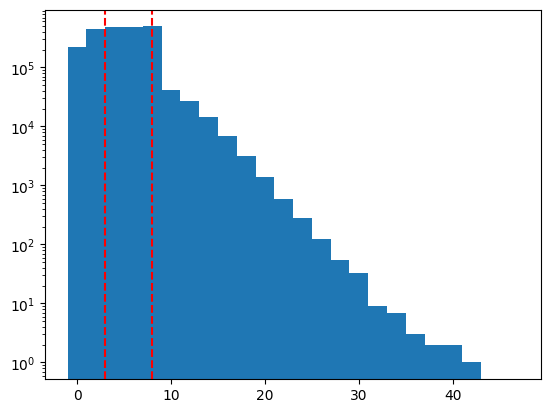

In [16]:
import matplotlib.pyplot as plt
import dask.array as da

# вычисляем статистики по столбцу n_ingredients
stats = recipes['n_ingredients'].compute().describe()

# считаем значения для построения гистограммы
hist, edges = da.histogram(recipes['n_ingredients'], bins=range(0, 50, 2))

# визуализируем результаты
plt.bar(edges[:-1].compute(), hist.compute(), width=2)
plt.axvline(x=stats['25%'], color='r', linestyle='--')
plt.axvline(x=stats['75%'], color='r', linestyle='--')
plt.yscale('log')
plt.show()


<p class="task" id="6"></p>

6\. Напишите функции:
* `minutes_to_hours(df)`, которая принимает на вход фрейм и заменяет столбец `minutes` на столбец `hours` с соответствующим преобразованием чисел;
* `extract_ymd(df)`, которая добавляет 3 столбца: `year`, `month` и `day`, полученные на основе столбца `submitted`;
* `add_month_name(df)`, которая добавляет категориальный столбец `month_name` с названием месяца из даты и вызывает для него метод `.cat.as_known()`. 

Создайте фрейм `recipes_pipe` путем цепочки вызовов метода `pipe` с применением данных функций. Выведите на экран строку, соответствующую рецепту с id=683970. Для отбора строки воспользуйтесь методом `query`.

In [17]:
import pandas as pd

def hours_to_minutes(df):
    df['hours'] = df['minutes'] / 60
    df = df.drop('minutes', axis=1)
    return df

def extract_ymd(df):
    df['year'] = df['submitted'].dt.year
    df['month'] = df['submitted'].dt.month
    df['day'] = df['submitted'].dt.day
    return df

def add_month_name(df):
    df['month_name'] = dd.to_datetime(df['submitted']).dt.month_name()
    df['month_name'] = df['month_name'].astype('category').cat.as_known()
    return df

In [18]:
recipes_pipe = (recipes.pipe(hours_to_minutes)
                      .pipe(extract_ymd)
                      .pipe(add_month_name))

In [19]:
recipes_pipe.query('id == 683970').compute()

,id,name,contributor_id,submitted,n_steps,description,n_ingredients,hours,year,month,day,month_name
0,683970,vant ivoire mickies nothing,803776,2019-08-22,4.0,pat and gina neely and their family own and op...,9,0.55,2019,8,22,August


<p class="task" id="7"></p>

7\. Используя результат предыдущей задачи, постройте сводную таблицу при помощи метода `pivot_table`, где по строкам располагаются года, по столбцам - названия месяцев, а в ячейках содержится средняя длина рецептов (в часах) в данный год и месяц. Выведите таблицу на экран. Выведите на экран информацию за апрель 1970-1975 годов (включительно).

In [20]:
# Строим сводную таблицу
pivot = recipes_pipe.pivot_table(index='year', columns='month_name', values='hours', aggfunc='mean')

In [21]:
# Выводим таблицу на экран
pivot.compute()

month_name,April,August,December,February,January,July,June,March,May,November,October,September
year,,,,,,,,,,,,
1970,0.535253,0.544904,0.535515,0.531530,0.532693,0.542781,0.544243,0.528301,0.536688,0.537969,0.532659,0.538930
1971,0.547731,0.530590,0.543796,0.533528,0.533237,0.545502,0.536644,0.535626,0.529507,0.531603,0.542461,0.545521
1972,0.531383,0.543788,0.540724,0.527673,0.527548,0.539933,0.530001,0.543361,0.539681,0.545566,0.536516,0.542677
1973,0.533646,0.546603,0.542902,0.538645,0.539917,0.530634,0.535194,0.533162,0.534956,0.538673,0.535226,0.528227
1974,0.540382,0.528316,0.535279,0.539811,0.535436,0.542733,0.532864,0.540594,0.542213,0.537463,0.536957,0.536616
1975,0.535514,0.534260,0.534445,0.533850,0.543938,0.538529,0.534805,0.539711,0.530531,0.541481,0.529238,0.548624
1976,0.543596,0.536620,0.532532,0.534188,0.548785,0.540760,0.528133,0.538327,0.537886,0.532967,0.540424,0.542933
1977,0.534943,0.536607,0.541353,0.537868,0.531178,0.542600,0.538966,0.532360,0.533895,0.536143,0.529759,0.531099
1978,0.536417,0.540905,0.540035,0.533373,0.538842,0.539100,0.539322,0.529556,0.537688,0.534920,0.545526,0.545815


In [22]:
# Выводим информацию за апрель 1970-1975 годов
recipes_pipe.query('submitted.dt.year.between(1970, 1975) & (submitted.dt.month == 4)').compute()

,id,name,contributor_id,submitted,n_steps,description,n_ingredients,hours,year,month,day,month_name
49,1347893,honeybun eggo icebox kachman tangier 415cals,27643,1974-04-13,4.0,a delicious meal that tastes amazing. if you p...,5,0.016667,1974,4,13,April
350,1423845,suqaar sudani,28201,1971-04-19,3.0,i've just been given this simple recipe and ca...,3,0.466667,1971,4,19,April
369,762744,twyla bonstrs,846243,1975-04-18,5.0,"a coworker lent me a book titled ""breads of ne...",7,0.033333,1975,4,18,April
1102,1401163,lombo happia mexibird piggies gut scorched gon...,52074,1972-04-20,5.0,this recipe has been in my family for generati...,8,0.883333,1972,4,20,April
1127,1280741,stuff cheddary foodtv bytodd donauwellen obas ...,294393,1974-04-17,2.0,"this is a very delicious seafood quiche, i hav...",5,0.733333,1974,4,17,April
...,...,...,...,...,...,...,...,...,...,...,...,...
278857,970424,byron opener please rendezvous alcachofas,1771,1971-04-12,4.0,salty and tart ... the perfect condiment for c...,4,0.450000,1971,4,12,April
278858,1638587,schreiber sharbat influnced wopatui,83093,1973-04-04,3.0,thinly sliced vegetables transform into edible...,7,0.416667,1973,4,4,April
278910,2182152,brith,50757,1973-04-05,1.0,i love to make these after mexican meals. they...,6,0.416667,1973,4,5,April
278921,2029438,frostings padang expressive twister sheet lurline,108846,1975-04-05,6.0,these pickles are so much better tasting then ...,2,0.066667,1975,4,5,April


In [23]:
pivot['April'][1970:1975].compute()

year
1970    0.535253
1971    0.547731
1972    0.531383
1973    0.533646
1974    0.540382
1975    0.535514
Name: April, dtype: float64

<p class="task" id="8"></p>

8\. В архиве `recipes_additional.zip` находятся файлы, содержащие информацию об рецептах блюд, полученные из другого источника. В связи с этим названия и количество столбцов в этих данных отличаются от того, что находится в архиве `recipes_full.zip`.

Объедините два набора набора данных (добавьте строки из одного набора данных к другому), согласовав названия столбцов и форматы данных. Итоговый фрейм должен содержать следующие колонки: `id`, `name`, `minutes`, `contributor_id`, `submitted`, `n_steps`, `description`, `n_ingredients`, `#tags` и `view_30_days`. Добавьте столбец `dset` с информацией о том, из какого датасета была получены данные.

Выведите на экран количество пропусков в каждом из столбцов полученной таблицы и общее количество строк в ней.

In [24]:
import pandas as pd

# загрузка двух наборов данных
recipes_full = dd.read_csv("recipes_full/recipes_full_*.csv", 
                      parse_dates = ["submitted"], dtype={'minutes': 'float64','n_steps': 'float64'})

recipes_additional = dd.read_csv("recipes_additional/recipes_additional_*.csv")

In [25]:
recipes_full = recipes_full.dropna()
recipes_additional = recipes_additional.dropna()

In [26]:
recipes_full.head(5)

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,683970,vant ivoire mickies nothing,33.0,803776,2019-08-22,4.0,pat and gina neely and their family own and op...,9
1,1089012,kremsils mariposa baccala cookies class borage...,23.0,51579,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5
2,1428572,tania lander,0.0,68884,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5
3,1400250,heloise milli asher doogh zojirushi,24.0,678862,2018-04-29,3.0,delicious cream cheese and peach filled cresce...,1
4,387709,nutty chocolate chunk cookies,47.0,489552,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10


In [27]:
recipes_additional.head(5)

,name,description,hours,date_of_publication,#tags,#ingredients,recipe_id,views_30_days
0,blue cheese tenders,found this recipe in my mom's older recipes. ...,0.333333,01/02/2008,12,5,52604,2001
1,hindi frappes tikkis siro changling anya jerkll,this is one i found on a post-it in my kitchen...,0.550000,25/06/1983,13,3,1ef55e,4691
2,navratan padma beehoon contest carrot,ok...here in the us avocados are used in savor...,0.433333,19/12/2007,9,5,6ccf2,3823
3,camptown two hurry laddi,i got this out of southern living magazine and...,0.133333,06/11/1998,3,4,6bb49,3202
4,down on the farm sausage bake,definite comfort food for me and my family.,1.250000,16/10/2002,5,13,dd23,2143


In [28]:
def minutes_to_hours(df):
    df['minutes'] = df['hours'] * 60
    df = df.drop('hours', axis=1)
    return df

In [29]:
recipes_additional = recipes_additional.pipe(minutes_to_hours)

In [30]:
# переименование столбцов
recipes_additional = recipes_additional.rename(columns={'#ingredients': 'n_ingredients', 
                                                        'date_of_publication': 'submitted',
                                                        'recipe_id': 'id'})

In [31]:
recipes_full['dset'] = 'full'
recipes_additional['dset'] = 'additional'

In [32]:
recipes_full.head(5)

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients,dset
0,683970,vant ivoire mickies nothing,33.0,803776,2019-08-22,4.0,pat and gina neely and their family own and op...,9,full
1,1089012,kremsils mariposa baccala cookies class borage...,23.0,51579,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5,full
2,1428572,tania lander,0.0,68884,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5,full
3,1400250,heloise milli asher doogh zojirushi,24.0,678862,2018-04-29,3.0,delicious cream cheese and peach filled cresce...,1,full
4,387709,nutty chocolate chunk cookies,47.0,489552,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10,full


In [33]:
recipes_additional.head(5)

,name,description,submitted,#tags,n_ingredients,id,views_30_days,minutes,dset
0,blue cheese tenders,found this recipe in my mom's older recipes. ...,01/02/2008,12,5,52604,2001,20.0,additional
1,hindi frappes tikkis siro changling anya jerkll,this is one i found on a post-it in my kitchen...,25/06/1983,13,3,1ef55e,4691,33.0,additional
2,navratan padma beehoon contest carrot,ok...here in the us avocados are used in savor...,19/12/2007,9,5,6ccf2,3823,26.0,additional
3,camptown two hurry laddi,i got this out of southern living magazine and...,06/11/1998,3,4,6bb49,3202,8.0,additional
4,down on the farm sausage bake,definite comfort food for me and my family.,16/10/2002,5,13,dd23,2143,75.0,additional


In [34]:
recipes = pd.concat([recipes_full.compute(), recipes_additional.compute()], ignore_index=True)

In [35]:
recipes

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients,dset,#tags,views_30_days
0,683970,vant ivoire mickies nothing,33.0,803776.0,2019-08-22 00:00:00,4.0,pat and gina neely and their family own and op...,9,full,NaN,NaN
1,1089012,kremsils mariposa baccala cookies class borage...,23.0,51579.0,2013-03-02 00:00:00,1.0,"a light, tasty and easy to put together chicke...",5,full,NaN,NaN
2,1428572,tania lander,0.0,68884.0,1980-11-09 00:00:00,1.0,a delicious melt in your mouth appetizer. for ...,5,full,NaN,NaN
3,1400250,heloise milli asher doogh zojirushi,24.0,678862.0,2018-04-29 00:00:00,3.0,delicious cream cheese and peach filled cresce...,1,full,NaN,NaN
4,387709,nutty chocolate chunk cookies,47.0,489552.0,2009-08-31 00:00:00,8.0,everyone loves these buttery cookies chock ful...,10,full,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3124877,20eadf,plas hachis,35.0,NaN,29/06/1997,NaN,"if you like the sound of this, you are gonna l...",1,additional,5.0,667.0
3124878,14d0d8,stephen jackpot guatemalan bredie cocoatana ma...,42.0,NaN,16/09/1981,NaN,a cool and creamy dessert!,9,additional,10.0,2269.0
3124879,1c0728,derves camp schmere krbissuppe fldekager,15.0,NaN,22/01/1999,NaN,quick and easy. tasty alternative to tradition...,4,additional,5.0,681.0
3124880,eb528,texans zuring mumble limas bouclair besan duvall,59.0,NaN,07/02/1973,NaN,5-ingredient fix contest entry. tasty little ...,5,additional,9.0,3683.0


In [36]:
print(recipes.isnull().sum())
print("Total rows:", len(recipes))

id                      0
name                    0
minutes                 0
contributor_id     956382
submitted               0
n_steps            956382
description             0
n_ingredients           0
dset                    0
#tags             2168500
views_30_days     2168500
dtype: int64
Total rows: 3124882
